In [1]:
import torch
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.ae_module import AutoencoderKL

In [ ]:
ckpt_ae_path="trained_ckpts_optimised/12km/VAE_ckpts/VAE_levels_latentdim_128_klweight_0.01_checkpoint.ckpt"

In [19]:
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.ae_module import AutoencoderKL

in_dim = 2
latent_dim = 128
levels = 2
min_ch = 16
ch_mult = 4
out_dim = 2

encoder = SimpleConvEncoder(in_dim=in_dim, levels=levels, min_ch=min_ch, ch_mult=ch_mult)
decoder = SimpleConvDecoder(in_dim=latent_dim, levels=levels, min_ch=min_ch, out_dim=out_dim)

vae = AutoencoderKL(encoder=encoder, decoder=decoder, latent_dim=latent_dim)

normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=32, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=512, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=512, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}


In [20]:
ckpt = torch.load(ckpt_ae_path, map_location="cpu")
state_dict = ckpt["state_dict"] if "state_dict" in ckpt else ckpt

filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("unet_regr")}

vae.load_state_dict(filtered_state_dict, strict=False)
vae.eval()

AutoencoderKL(
  (encoder): SimpleConvEncoder(
    (net): Sequential(
      (0): ResBlock2D(
        (proj): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): SiLU()
        (act2): SiLU()
        (norm1): GroupNorm(1, 2, eps=1e-05, affine=True)
        (norm2): GroupNorm(1, 16, eps=1e-05, affine=True)
        (sequence): Sequential(
          (0): GroupNorm(1, 2, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(1, 16, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
      (2): ResBlock2D(
        (proj): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))


In [21]:
x = torch.randn(1, in_dim, 240, 370)

encoder = SimpleConvEncoder(in_dim=in_dim, levels=levels, min_ch=min_ch, ch_mult=ch_mult)
h = encoder(x)
print("Encoder output shape:", h.shape)

to_moments = torch.nn.Conv2d(h.shape[1], 2*latent_dim, 1)
moments = to_moments(h)
mean, logvar = torch.chunk(moments, 2, dim=1)
print("Latent mean shape:", mean.shape)

decoder = SimpleConvDecoder(in_dim=latent_dim, levels=levels, min_ch=min_ch, out_dim=out_dim)
z = torch.randn(1, latent_dim, h.shape[2], h.shape[3])
out = decoder(z)
print("Decoder output shape:", out.shape)

normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=16, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=32, norm_type=group, norm_kwargs={'num_groups': 1}
Encoder output shape: torch.Size([1, 32, 60, 92])
Latent mean shape: torch.Size([1, 128, 60, 92])
normalization called with channels=512, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=512, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
normalization called with channels=2, norm_type=group, norm_kwargs={'num_groups': 1}
Decoder output shape: torch.Size([1, 2, 240, 368])


In [22]:
with torch.no_grad():

    result=vae.encode(x)
    print(type(result))
    print(result)

<class 'tuple'>
(tensor([[[[-5.1903e-02, -4.8554e-02, -1.4275e-01,  ...,  2.9719e-02,
           -6.3380e-02, -1.8972e-02],
          [-1.1223e-01,  5.0211e-02,  3.3648e-02,  ...,  2.2903e-02,
            1.1581e-01,  4.4388e-02],
          [ 7.6213e-03, -1.0655e-01,  4.9550e-03,  ..., -2.4457e-02,
           -7.4072e-02,  7.4856e-02],
          ...,
          [ 7.6297e-02,  4.1886e-02, -3.0819e-03,  ...,  9.7982e-02,
            9.2309e-03, -8.4792e-02],
          [-1.7630e-02,  4.2407e-02, -4.6865e-02,  ...,  5.3491e-02,
            1.5568e-01,  4.5309e-02],
          [ 9.1103e-03, -1.1576e-01,  3.1084e-02,  ..., -5.2925e-02,
           -3.8493e-03,  2.7013e-02]],

         [[-4.6479e-02, -3.1825e-02, -2.2402e-02,  ..., -3.7656e-02,
           -3.1302e-02, -3.9129e-02],
          [-4.5017e-02,  1.5326e-02,  2.1516e-02,  ...,  5.8564e-03,
            6.5559e-02,  1.2861e-02],
          [-2.4892e-04, -1.7593e-02,  5.5343e-03,  ..., -5.5132e-03,
            7.0351e-03,  2.7292e-02],
   

In [23]:
print("Mean abs weight:", next(vae.parameters()).abs().mean().item())

Mean abs weight: 0.019435953348875046


In [ ]:
with torch.no_grad():
    mean, logvar = vae.encode(x)



    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mean + eps * std
    print("Encoded latent shape:", z.shape)
    x_recon = vae.decode(z)
    print("Reconstructed output shape:", x_recon.shape)

Encoded latent shape: torch.Size([1, 128, 60, 92])
Reconstructed output shape: torch.Size([1, 2, 240, 368])


In [ ]:
import xarray as xr
import torch
import matplotlib.pyplot as plt
import numpy as np

precip_path = "../Dataset_Setup_I_Chronological_12km/RhiresD_input_val_scaled.nc"
temp_path = "../Dataset_Setup_I_Chronological_12km/TabsD_input_val_scaled.nc"

precip_ds = xr.open_dataset(precip_path)
temp_ds = xr.open_dataset(temp_path)

precip_frame = precip_ds['RhiresD'].isel(time=25).values  
temp_frame = temp_ds['TabsD'].isel(time=25).values    

precip_frame = np.nan_to_num(precip_frame, nan=0.0)
temp_frame = np.nan_to_num(temp_frame, nan=0.0)


In [ ]:
#elevation
elevation= "../elevation.tif"

In [ ]:
import rasterio

In [ ]:
with rasterio.open(elevation) as src:
    elevation = src.read(1).astype(np.float32)
elevation = np.nan_to_num(elevation, nan=0.0)

if elevation.shape != precip_frame.shape:
    from skimage.transform import resize
    elevation = resize(elevation, precip_frame.shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)


In [ ]:
from models.unet_module import DownscalingUnet

unet_ckpt_path = "trained_ckpts_optimised/12km/LDM_conditional.models.unet_module.DownscalingUnetLightning_logtransform_lr0.001_precip_loss_weight1.0_1.0_crps[0, 1]_factor0.5_pat3.ckpt.ckpt"
unet_ckpt = torch.load(unet_ckpt_path, map_location="cpu", weights_only=False)
unet = DownscalingUnet(in_ch=3, out_ch=2, features=[64,128,256,512])
unet.load_state_dict(unet_ckpt["state_dict"], strict=False)
unet.eval()

DownscalingUnet(
  (encoder): ModuleList()
  (decoder): ModuleList()
  (e1): EncoderBlock(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncoderBlock(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
frame = torch.from_numpy(
    np.stack([precip_frame, temp_frame, elevation], axis=0)
).float().unsqueeze(0)

In [ ]:
with torch.no_grad():
    regression_output = unet(frame)  # shape [1, 2, H, W]

# Only use the first two channels for residuals
residuals = frame[:, :2, :, :] - regression_output

with torch.no_grad():
    mean, logvar = vae.encode(residuals)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mean + eps * std
    recon_residuals = vae.decode(z)


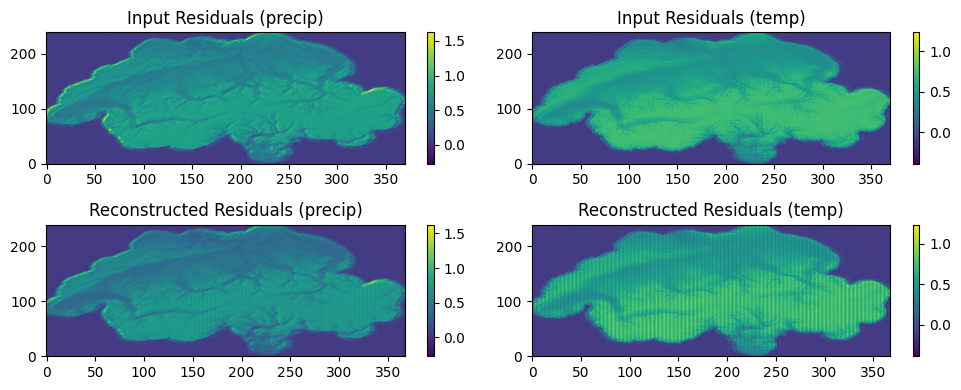

In [ ]:
vmin_precip = min(residuals[0,0].min().item(), recon_residuals[0,0].min().item())
vmax_precip = max(residuals[0,0].max().item(), recon_residuals[0,0].max().item())
vmin_temp = min(residuals[0,1].min().item(), recon_residuals[0,1].min().item())
vmax_temp = max(residuals[0,1].max().item(), recon_residuals[0,1].max().item())

plt.figure(figsize=(10, 4))

#using flipud for flipping the plots
for i, var in enumerate(['precip', 'temp']):
    plt.subplot(2, 2, 1 + i)
    plt.title(f"Input Residuals ({var})")
    vmin = vmin_precip if var == 'precip' else vmin_temp
    vmax = vmax_precip if var == 'precip' else vmax_temp
    plt.imshow(np.flipud(residuals[0, i].cpu().numpy()), aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.subplot(2, 2, 3 + i)
    plt.title(f"Reconstructed Residuals ({var})")
    plt.imshow(np.flipud(recon_residuals[0, i].cpu().numpy()), aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
plt.tight_layout()
plt.show()